In [1]:
import pandas as pd
import geopandas as gpd
from tobler.util import h3fy
import math
import utm

import HoneyPie.statistic_operations as statistic
import HoneyPie.objects_location as objects_location
import HoneyPie.direction as direction
import HoneyPie.filling_hex as filling_hex
import HoneyPie.algorithm as algorithm

c:\Users\Way51\Documents\GitHub\HoneyPie\.venv\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
# Define your parameters

WIND_DIRECTION = 'south_west' # set an area destination

# set percent od every area you need
landuse_percent = {
    'living': 0.543,
    'social': 0.066,
    'industrial': 0.061,
    'transport': 0.077,
    'recreation': 0.253
}

In [3]:
# load files of the territory and city
territory = gpd.read_file('example_files/siver.geojson').to_crs('EPSG:4326')
city = gpd.read_file('example_files/СНП Сиверского городского поселения.geojson').to_crs('EPSG:4326')
region = gpd.read_file('example_files/Сиверское городское поселение.geojson').to_crs('EPSG:4326')

# all buildings - living
buildings = gpd.read_file('example_files/balanced_buildings.geojson')
buildings['building:levels'] = buildings['building:levels'].astype(int)
buildings_p = buildings.copy()
buildings_p['geometry'] = buildings_p['geometry'].centroid.to_crs('EPSG:4326')

In [4]:
# CONSTANTS FOR THIS PROJECT
utm_system = utm.from_latlon(territory.loc[0, 'geometry'].centroid.y, territory.loc[0, 'geometry'].centroid.x) # find UTM zone
LOCAL_CRS = 'EPSG:326' + str(utm_system[2])
centre_territory = territory.to_crs(LOCAL_CRS).loc[0, 'geometry'].centroid
territory_area_he = territory.to_crs(LOCAL_CRS).area / 10000

In [5]:
# create hexagones for future analysis hex_area = 1.26 he
hex_city = h3fy(city, resolution=10, clip=True, buffer=False, return_geoms=True).reset_index()
hex_territory = h3fy(territory, resolution=10, clip=True, buffer=False, return_geoms=True).to_crs(LOCAL_CRS).reset_index()

# set_default_parameters
hex_territory['landuse'] = 'not_defined'
hex_territory['func_zone'] = 'not_defined'

hex_territory['score_industrial'] = 0
hex_territory['score_social'] = 0
hex_territory['score_middle_living'] = 0
hex_territory['score_low_living'] = 0
hex_territory['score_cottage_living'] = 0
hex_territory['score_garden'] = 0
hex_territory['score_park'] = 0
hex_territory['score_green_buffer'] = 0
hex_territory['fixed'] = 0

# get base data merge hex and floors
for i in range(len(hex_city)):
        # Выбор точек внутри полигона
    points_within_polygon = buildings_p[buildings_p.geometry.within(hex_city.geometry[i])]
    # Группировка значений
    grouped_values = points_within_polygon.groupby('is_living')['building:levels'].mean().reset_index()
    hex_city.loc[i, 'Floors'] = grouped_values['building:levels'].max()
    grouped_values['population'] = 0

# calculate nececcary parameters
living_area = territory_area_he * landuse_percent['living']
social_area = territory_area_he * landuse_percent['social']
industrial_area = territory_area_he * landuse_percent['industrial']
transport_area = territory_area_he * landuse_percent['transport']
recreation_area = territory_area_he * landuse_percent['recreation']

hex_count = {}
hex_count['middle_living'] = math.ceil(living_area * 0.10)
hex_count['low_living'] = math.ceil(living_area * 0.30)
hex_count['cottage_living'] = math.ceil(living_area * 0.60)
hex_count['industrial']  = math.ceil(industrial_area)
hex_count['recreation']  = math.ceil(recreation_area)
hex_count['social0'] = math.ceil(social_area)


C:\Users\Way51\AppData\Local\Temp\ipykernel_14188\890357918.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hex_count['middle_living'] = math.ceil(living_area * 0.10)
C:\Users\Way51\AppData\Local\Temp\ipykernel_14188\890357918.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hex_count['low_living'] = math.ceil(living_area * 0.30)
C:\Users\Way51\AppData\Local\Temp\ipykernel_14188\890357918.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hex_count['cottage_living'] = math.ceil(living_area * 0.60)
C:\Users\Way51\AppData\Local\Temp\ipykernel_14188\890357918.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(

In [6]:
# Assessment territory for sun, wind, exist_city
hex_territory = algorithm.TerritoryAssessment.exist_city(hex_territory, hex_city)
hex_territory = algorithm.TerritoryAssessment.sun(hex_territory)
hex_territory = algorithm.TerritoryAssessment.wind(hex_territory, WIND_DIRECTION)

# plot scores
hex_territory.plot('score_low_living', cmap = 'Set2', legend = True, figsize=(15,15))

In [ ]:
# Main part of the algorithm
# Firstly set all living zone
hex_territory = algorithm.TerritoryPlanner.set_middle_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_low_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_cottage_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)

# And plot function zones
hex_territory.plot('func_zone', cmap = 'Set2', legend = True, figsize=(15,15))

In [ ]:
# Secondly set industrial and recreation
hex_territory = algorithm.TerritoryPlanner.set_industrial(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_green_buffer(hex_territory, hex_count, WIND_DIRECTION, centre_territory)

# Fill in population for all living zones
hex_territory = filling_hex.ModifyHex.recover_population(hex_territory)

# And plot function zones
hex_territory.plot('func_zone', cmap = 'Set2', legend = True, figsize=(15,15))

In [ ]:
# Plot map of the population
hex_territory.plot('population', cmap = 'Set2', legend = True, figsize=(15,15))

In [11]:
# Create network for future analyses
ntw = objects_location.SocialObjectsLocation.network_contruction(hex_territory, LOCAL_CRS)

In [ ]:
# Find the best place for social objects
hex_territory = objects_location.SocialObjectsLocation.school(hex_territory, ntw, LOCAL_CRS)
hex_territory = objects_location.SocialObjectsLocation.kindergarten(hex_territory, ntw, LOCAL_CRS)
hex_territory.plot('func_zone', cmap = 'Set2', legend = True, figsize=(15,15))

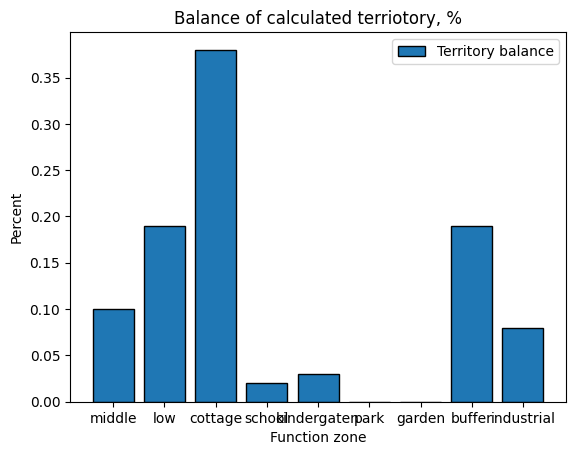

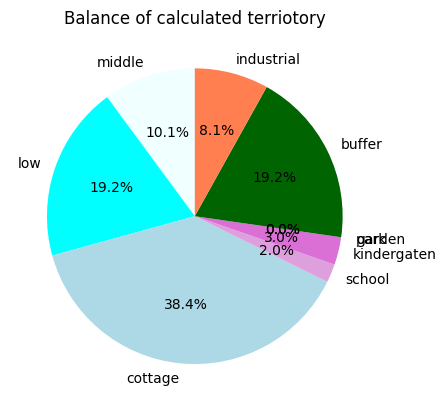

In [ ]:
# First variant of the territory balance
statistic.plot_balance_calculated(hex_territory)

In [ ]:
# Fix social objects and redefine function zones
hex_territory_good = hex_territory[hex_territory['fixed'] == 'fix'].reset_index(drop=True)
hex_territory = hex_territory[hex_territory['fixed'] != 'fix'].reset_index(drop=True)
hex_territory['func_zone'] = 'not_defined'
hex_territory['landuse'] = 'not_defined'

hex_territory = algorithm.TerritoryPlanner.set_middle_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_low_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_cottage_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_industrial(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_green_buffer(hex_territory, hex_count, WIND_DIRECTION, centre_territory)

hex_territory = pd.concat([hex_territory, hex_territory_good]).reset_index(drop=True)

hex_territory.plot('func_zone', cmap = 'Set2', legend = True, figsize=(15,15))

In [ ]:
# Change social objects to garden and relocate schools and gardens
hex_territory.loc[hex_territory[hex_territory['fixed'] == 'fix'].index, 'func_zone'] = 'garden'

hex_territory = objects_location.SocialObjectsLocation.school(hex_territory, ntw, LOCAL_CRS)
hex_territory = objects_location.SocialObjectsLocation.kindergarten(hex_territory, ntw, LOCAL_CRS)

hex_territory.plot('func_zone', cmap = 'Set2', legend = True, figsize=(15,15))

In [ ]:
# Fix social objects and redefine function zones
hex_territory_good = hex_territory[hex_territory['fixed'] == 'fix'].reset_index(drop=True)
hex_territory = hex_territory[hex_territory['fixed'] != 'fix'].reset_index(drop=True)
hex_territory['func_zone'] = 'not_defined'
hex_territory['landuse'] = 'not_defined'

hex_territory = algorithm.TerritoryPlanner.set_middle_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_low_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_cottage_living(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_industrial(hex_territory, hex_count, WIND_DIRECTION, centre_territory)
hex_territory = algorithm.TerritoryPlanner.set_green_buffer(hex_territory, hex_count, WIND_DIRECTION, centre_territory)

hex_territory = pd.concat([hex_territory, hex_territory_good]).reset_index(drop=True)

hex_territory.plot('func_zone', cmap = 'Set2', legend = True, figsize=(15,15))

# Fill in population for all living zones
hex_territory = filling_hex.ModifyHex.recover_population(hex_territory)

# Set the right landuse
hex_territory = filling_hex.ModifyHex.recover_landuse(hex_territory)

In [ ]:
hex_territory.plot('func_zone', cmap = 'Set2', legend = True, figsize=(15,15))

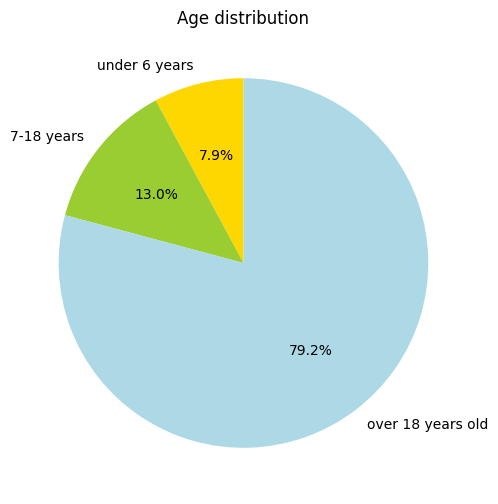

()

In [17]:
statistic.plot_population(hex_territory)

In [ ]:
# Balance of landuse
statistic.StatsLanduse.plot_balance_calculated(hex_territory, territory_area_he)

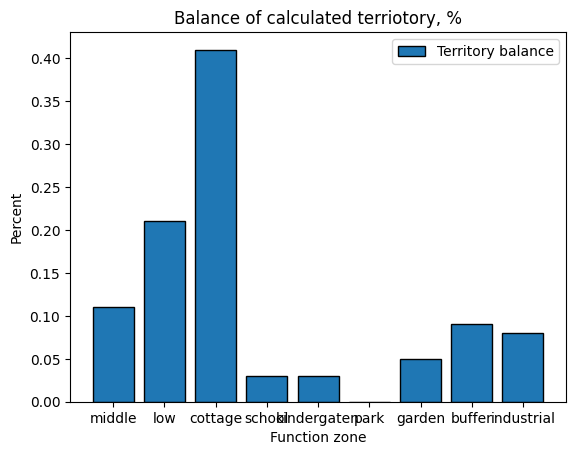

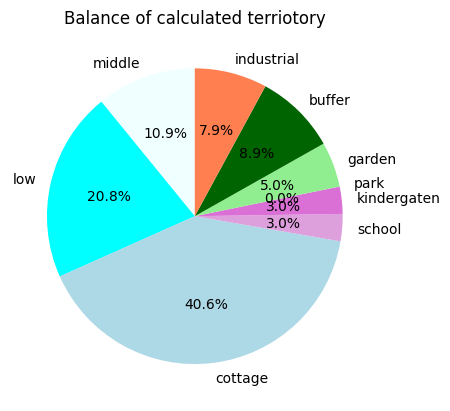

In [ ]:
# Balance of function zones
statistic.StatsFuncZones.plot_balance_calculated(hex_territory, territory_area_he)

In [ ]:
statistic.StatsSocial.print_social_objects(hex_territory)